# 1. Determining optimal probability cut-off
Predicted probability is a number between **0** and **1**. Traditionally, probability **>= 0.5** is a *cut-off point* used for converting predicted proabability to **1** (*positive*) otherwise **0** (*negative*). This logic works well when your training data set has equal example of positive and negative samples, however this is not the case in real world scenarios.

The solution is to find the optimal *cut-off* point, that is the point where **true positive rate** is high and the **false positive rate** is low. Anything above this threshold can be labeled as **1** else **0**. Let's understand this better with an example.

We'll be using the dataset from the **UCI repository**, dataset *Pima Indian diabetes*: 2 classes, 8 attributes, 768 instances, 500 (65.1%) negative (class1), and 268 (34.9%) positive tests for diabetes (class2). All patients were females at least 21 years old of Pima Indian heritage.

Attributes used:
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

## Exercise 1: Read the input data

In [1]:
# Load libraries
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Read the data from the Diabetes.csv file
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Lab09/Diabetes.csv')
print(df.head())
print()

# Target variable % distribution
print (df['class'].value_counts(normalize = True))

X = df.iloc[:, :8]    # Independent variables
Y = df['class']       # Dependent variable

Mounted at /content/drive
   preg_count  glucose_concentration  blood_pressure  skin_thickness  \
0           6                    148              72              35   
1           1                     85              66              29   
2           8                    183              64               0   
3           1                     89              66              23   
4           0                    137              40              35   

   serum_insulin   bmi  pedigree_function  age  class  
0              0  33.6              0.627   50      1  
1              0  26.6              0.351   31      0  
2              0  23.3              0.672   32      1  
3             94  28.1              0.167   21      0  
4            168  43.1              2.288   33      1  

class
0    0.651042
1    0.348958
Name: proportion, dtype: float64


**Questions:**
1. What do the numbers **0** and **1** in the *class* column mean?
2. In your opinion, is the dataset balanced or not? Why do you think so?

**Answers:**


1. Based on the dataset description at the beginning of the notebook, the `class` column represents the test result for diabetes. The value **0** likely corresponds to a negative test result (no diabetes), and the value **1** likely corresponds to a positive test result (diabetes). Looking at the output of `df['class'].value_counts(normalize = True)`, it shows the proportions of 0s and 1s, confirming these are the two classes.

2. I'd say the dataset is not balanced. The output from `df['class'].value_counts(normalize = True)` clearly shows that about 65% of the instances belong to class 0 (negative) and only about 35% belong to class 1 (positive). This imbalance means there are significantly more examples of one class than the other, which can be a challenge for some machine learning models.

## Exercise 2: Model building and evaluation

In [3]:
# Evaluate the model by splitting into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# Instantiate a logistic regression model, and fit
model = LogisticRegression(max_iter=300)
model = model.fit(X_train, Y_train)

# Predict class labels for the test set
# The predict() fuction converts probability values >= 0.5 to 1 else 0
Y_pred = model.predict(X_test)
print('Example results of the predict() function:', Y_pred[0:5])

# Generate class probabilities with the predict_proba() function
# Notice that 2 elements will be returned in probs array,
# 1st element is a probability for negative class,
# 2nd element gives probability for positive class
probs = model.predict_proba(X_test)
Y_pred_prob = probs[:, 1]
print('\nExample results of the predict_proba() function:\n', probs[0:5, :])

# Generate evaluation metrics
print ('\nAccuracy:', metrics.accuracy_score(Y_test, Y_pred))

Example results of the predict() function: [0 0 0 0 0]

Example results of the predict_proba() function:
 [[0.95335372 0.04664628]
 [0.62878138 0.37121862]
 [0.87425744 0.12574256]
 [0.9472979  0.0527021 ]
 [0.8127693  0.1872307 ]]

Accuracy: 0.7748917748917749


 **Questions:**
1. What is a difference between the results returned by the predict() and predict_proba() functions?
 2. How would you use these functions when solving a binary classification task?

**Answers:**


1. The main difference is what they give you back. `predict()` gives you the final predicted class label (either 0 or 1 in a binary case) based on a default threshold (usually 0.5). It's like the model saying "Yep, this one is definitely a 1" or "Nope, this one is a 0". On the other hand, `predict_proba()` gives you the probability of the instance belonging to each class. So, for a binary classification, it would return an array like `[probability_of_class_0, probability_of_class_1]`. It's giving you a softer prediction, showing how confident the model is about each class.

2. When I'm working on a binary classification task, I'd use both but for different reasons. I'd use `predict()` when I need a clear, final decision for each instance – like assigning a label for deployment or making a definitive call. I'd use `predict_proba()` when I want to understand the model's confidence or when I need to adjust the decision threshold. For example, if it's really important to minimize false negatives (like in medical diagnosis), I might lower the threshold from 0.5 using the probabilities from `predict_proba()` to be more sensitive to positive cases.

## Exercise 3: Building the ROC curve

Area under the ROC curve (AUC): 0.8253827558420629


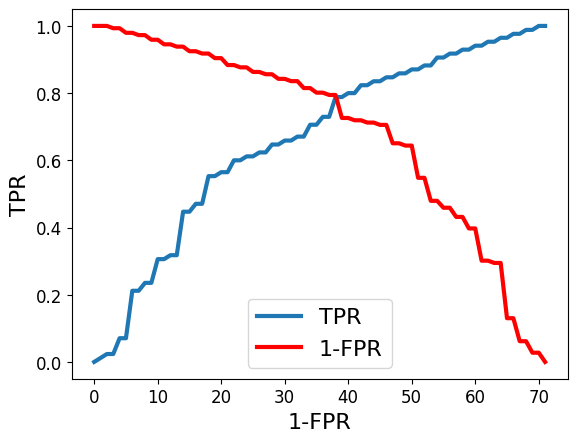

In [4]:
# Extract false positive rate (fpr), true positive rate (tpr) and thresholds
FPR, TPR, thresholds = metrics.roc_curve(Y_test, Y_pred_prob)
ROC_AUC = metrics.auc(FPR, TPR)
print ('Area under the ROC curve (AUC):', ROC_AUC)

i = np.arange(len(TPR))    # Index for df
ROC = pd.DataFrame({'FPR': pd.Series(FPR, index = i),
                    'TPR': pd.Series(TPR, index = i),
                    '1-FPR': pd.Series(1-FPR, index = i),
                    'tf': pd.Series(TPR-(1-FPR), index = i),
                    'thresholds': pd.Series(thresholds, index = i)})
ROC.iloc[(ROC.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(ROC['TPR'], label = 'TPR', lw=3)
plt.plot(ROC['1-FPR'], color = 'red', label = '1-FPR', lw=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.xlabel('1-FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
#plt.title('Receiver operating characteristic')
plt.show()

**Questions:**
1. What do the FPR and TPR parameters mean?
2. What is the AUC parameter used for?

**Answers:**


1. **FPR** stands for False Positive Rate, and **TPR** stands for True Positive Rate. In simpler terms, TPR (also called sensitivity or recall) is about how good your model is at catching the actual positive cases – out of all the real positives, what proportion did it correctly identify? FPR, on the other hand, is about how often your model incorrectly predicts a positive result when it's actually negative – out of all the real negatives, what proportion did it get wrong and call positive?

2. **AUC** stands for Area Under the ROC Curve. Think of it as a single number that summarizes the overall performance of your classifier across all possible thresholds. A higher AUC means your model is better at distinguishing between the positive and negative classes. An AUC of 1.0 means a perfect model, while an AUC of 0.5 means your model is performing no better than random guessing. It's a really useful metric, especially when you have imbalanced datasets.

## Exercise 4: Optimal cut-off
The optimal *cut-off* would be where **TPR** is high and **FPR** is low. In this case, **TPR-(1-FPR)** is **zero** or **near to zero**. To simplify finding **optimal probability threshold** and bring in re-usability, we may use a function to find the optimal probability **cut-off** point. The function used returns a list type with optimal **cut-off** value. The meaning of the parameters is as follows:
- **target** - matrix with dependent or target data, where rows are observations;
- **predicted** - matrix with predicted data, where rows are observations.

In [5]:
def Find_Optimal_Cutoff(target, predicted):
    FPR, TPR, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(TPR))
    ROC = pd.DataFrame({'tf': pd.Series(TPR-(1-FPR), index = i), 'threshold': pd.Series(threshold, index = i)})
    ROC_t = ROC.iloc[(ROC.tf-0).abs().argsort()[:1]]
    return list(ROC_t['threshold'])

In [6]:
# Find optimal probability threshold
# Note: probs[:, 1] will have the probability of being a positive label
threshold = Find_Optimal_Cutoff(Y_test, probs[:, 1])
print ('Optimal probability threshold:', threshold)

# Applying the threshold to the prediction probability
Y_pred_optimal = np.where(Y_pred_prob >= threshold, 1, 0)

# Let's compare the accuracy of traditional/normal approach vs. optimal cut-off
print ('\nAccuracy (normal):', metrics.accuracy_score(Y_test, Y_pred))
print ('Accuracy (optimal cut-off):', metrics.accuracy_score(Y_test, Y_pred_optimal))
print ('\nConfusion matrix (normal):\n', metrics.confusion_matrix(Y_test, Y_pred))
print ('\nConfusion matrix (optimal cut-off): \n', metrics.confusion_matrix(Y_test, Y_pred_optimal))

Optimal probability threshold: [0.36442080160399715]

Accuracy (normal): 0.7748917748917749
Accuracy (optimal cut-off): 0.7922077922077922

Confusion matrix (normal):
 [[129  17]
 [ 35  50]]

Confusion matrix (optimal cut-off): 
 [[116  30]
 [ 18  67]]


**Questions:**
1. How did type I and type II errors change after the application of the optimal cut-off?
2. Do you think this change is medically beneficial for patients? Justify your answer.

**Answers:**


1. Looking at the confusion matrices, let's break down Type I and Type II errors.
   - **Type I Error (False Positive):** This is when the model predicts a positive outcome (diabetes) but the actual outcome is negative. In the confusion matrix, this is the top-right cell.
     - Normal cut-off: 17
     - Optimal cut-off: 30
     So, Type I errors increased with the optimal cut-off.
   - **Type II Error (False Negative):** This is when the model predicts a negative outcome (no diabetes) but the actual outcome is positive. In the confusion matrix, this is the bottom-left cell.
     - Normal cut-off: 35
     - Optimal cut-off: 18
     So, Type II errors decreased significantly with the optimal cut-off.

2. Yes, I think this change is medically beneficial for patients, even though Type I errors went up. Here's why:
   - **Reduced Type II Errors are crucial in medical diagnosis:** A Type II error means a patient who *does* have diabetes is told they *don't*. This is really dangerous because they won't get the necessary treatment, which can lead to serious health complications. Reducing this type of error is usually a top priority in medical testing.
   - **Increased Type I Errors are less critical (in this context):** A Type I error means a patient who *doesn't* have diabetes is told they *might* have it. While this can cause anxiety and lead to further testing, it's less immediately harmful than missing a true case of diabetes. Further tests would likely clarify the situation.

   In this specific medical scenario, prioritizing the reduction of false negatives (Type II errors) by using the optimal cut-off seems like a medically responsible approach. It means fewer people with diabetes will be missed by the screening.

# 2. Rare event or unbalanced data set
Providing equal sample of positive and negative instances to the classification algorithm will result in optimal result. Dataset which are highly skewed towards one or more classes have proven to be a challenge.

Resampling is a common practice of addressing this issue. Although there are many techniques within re-sampling, here we'll be learning the 3 most popular techniques.

* **Random under-sampling** - reduce majority class to match minority class count.
* **Random over-sampling** - increase minority class by randomly picking samples within minority class till counts of both class match.
* **Synthetic Minority Over Sampling Technique (SMOTE)** - increase minority class by introducing synthetic examples through connecting all k (default = 5) minority class nearest negihbors using feature space similarity (Euclidean distance).

## Exercise 5: Generate the input data
A number of techniques have been implemented in **imbalanced-learn** python package. To install it, close Jupyter Notebook and enter the command in the console: **pip install -U imbalanced-learn**. Then, open Jupyter Notebook and continue with the exercises.

In [7]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [8]:
# Generate the dataset with 2 features to keep it simple
X, Y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_informative = 2,
                           n_redundant = 0,
                           weights = [0.8, 0.2],
                           random_state = 666)

print ('Negative class:', Y.tolist().count(0))
print ('Positive class:', Y.tolist().count(1))

Negative class: 802
Positive class: 198


**Question:**
1. On what basis can it be concluded that the data are unbalanced?

**Answer:**


You can conclude that the data are unbalanced by looking at the output of `Y.tolist().count(0)` and `Y.tolist().count(1)` from the `make_classification` function. The output shows that there are 802 instances of the negative class (0) and only 198 instances of the positive class (1). Since the counts of the two classes are significantly different, the dataset is unbalanced.

## Exercise 6: Applying the sampling techniques and plot the original vs. re-sampled

In [9]:
# Apply the Random Under-Sampling
RUS = RandomUnderSampler()
X_RUS, Y_RUS = RUS.fit_resample(X, Y)

# Apply the Random Over-Sampling
ROS = RandomOverSampler()
X_ROS, Y_ROS = ROS.fit_resample(X, Y)

# Apply regular SMOTE
SM = SMOTE()
X_SMOTE, Y_SMOTE = SM.fit_resample(X, Y)

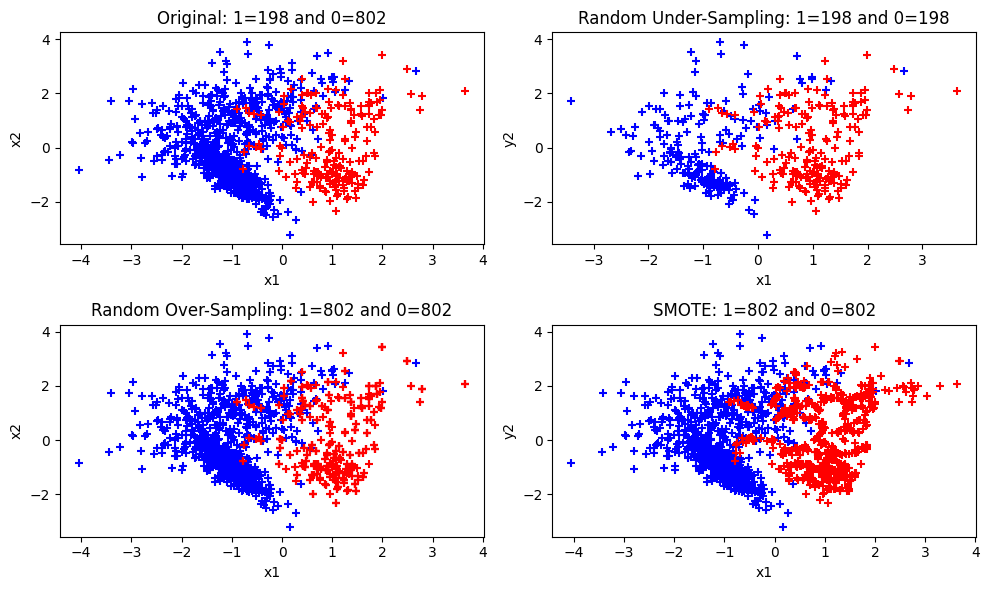

In [10]:
# Original vs resampled subplots
plt.figure(figsize = (10, 6))
plt.subplot(2, 2, 1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], marker = '+', color = 'blue')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], marker='+', color = 'red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original: 1=%s and 0=%s' %(Y.tolist().count(1), Y.tolist().count(0)))

plt.subplot(2, 2, 2)
plt.scatter(X_RUS[Y_RUS == 0, 0], X_RUS[Y_RUS == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_RUS[Y_RUS == 1, 0], X_RUS[Y_RUS == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('Random Under-Sampling: 1=%s and 0=%s' %(Y_RUS.tolist().count(1), Y_RUS.tolist().count(0)))

plt.subplot(2, 2, 3)
plt.scatter(X_ROS[Y_ROS == 0, 0], X_ROS[Y_ROS == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_ROS[Y_ROS == 1, 0], X_ROS[Y_ROS == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Over-Sampling: 1=%s and 0=%s' %(Y_ROS.tolist().count(1), Y_ROS.tolist().count(0)))

plt.subplot(2, 2, 4)
plt.scatter(X_SMOTE[Y_SMOTE == 0, 0], X_SMOTE[Y_SMOTE == 0, 1], marker = '+', color = 'blue')
plt.scatter(X_SMOTE[Y_SMOTE == 1, 0], X_SMOTE[Y_SMOTE == 1, 1], marker = '+', color = 'red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('SMOTE: 1=%s and 0=%s' %(Y_SMOTE.tolist().count(1), Y_SMOTE.tolist().count(0)))

plt.tight_layout()
plt.show()

**Questions:**
1. What is in your opinion the disadvantage of the Random Under-Sampling technique?
2. What are in your opinion the disadvantages of the Random Over-Sampling and SMOTE techniques?

**Answers:**


1. In my opinion, the biggest disadvantage of Random Under-Sampling is that you're throwing away data. You're randomly removing instances from the majority class to match the minority class count. If those removed instances contained important information or were representative of certain edge cases in the majority class, you lose that information, which could potentially hurt your model's performance on unseen data. It feels like you might be oversimplifying the dataset.

2. For Random Over-Sampling, a disadvantage is that you're just duplicating existing minority class instances. This doesn't add any new information to the dataset. It can lead to your model becoming too specific to the duplicated instances and potentially overfitting, especially if the original minority class had limited variability. It might make the model perform well on the training data but poorly on new, slightly different data.

   SMOTE is better because it creates synthetic examples, which adds some variation. However, a potential disadvantage is that these synthetic samples are generated along the lines connecting existing minority class neighbors. This can sometimes create synthetic samples in areas of the feature space that are actually occupied by the majority class, especially if the classes are not well-separated. This can make the decision boundary between the classes less clear and potentially introduce noise. Also, if you have a very sparse minority class, SMOTE might not be as effective.

## Exercise 7: Comparison of effectiveness of the re-sampling techniques
We'll build classification models for 3 re-sampled data and compare their accuracy using AUC.

In [11]:
from sklearn import tree
from sklearn import metrics

# Split data into train and test
from sklearn.model_selection import train_test_split

X_RUS_train, X_RUS_test, Y_RUS_train, Y_RUS_test = train_test_split(X_RUS, Y_RUS, test_size = 0.3)
X_ROS_train, X_ROS_test, Y_ROS_train, Y_ROS_test = train_test_split(X_ROS, Y_ROS, test_size = 0.3)
X_SMOTE_train, X_SMOTE_test, Y_SMOTE_train, Y_SMOTE_test = train_test_split(X_SMOTE, Y_SMOTE, test_size = 0.3)

# Build a decision tree classifier
clf = tree.DecisionTreeClassifier()
clf_rus = clf.fit(X_RUS_train, Y_RUS_train)
clf_ros = clf.fit(X_ROS_train, Y_ROS_train)
clf_smote = clf.fit(X_SMOTE_train, Y_SMOTE_train)

# Evaluate model performance
print ('RUS - Train AUC:', metrics.roc_auc_score(Y_RUS_train, clf.predict(X_RUS_train)))
print ('RUS - Test AUC:', metrics.roc_auc_score(Y_RUS_test, clf.predict(X_RUS_test)))
print ('\nROS - Train AUC:', metrics.roc_auc_score(Y_ROS_train, clf.predict(X_ROS_train)))
print ('ROS - Test AUC:', metrics.roc_auc_score(Y_ROS_test, clf.predict(X_ROS_test)))
print ('\nSMOTE - Train AUC:', metrics.roc_auc_score(Y_SMOTE_train, clf.predict(X_SMOTE_train)))
print ('SMOTE - Test AUC:', metrics.roc_auc_score(Y_SMOTE_test, clf.predict(X_SMOTE_test)))

RUS - Train AUC: 0.978593032957864
RUS - Test AUC: 0.9750990379173741

ROS - Train AUC: 0.9742657342657343
ROS - Test AUC: 0.981383712905452

SMOTE - Train AUC: 1.0
SMOTE - Test AUC: 0.935345944545219


**Questions:**
1. Which re-sampling technique did you find most effective? Justify your answer.
2. What other ways of assessing model quality could you recommend?

**Answers:**


1. Looking at the test AUC scores, Random Over-Sampling (ROS) seems to be the most effective technique in this case, with a test AUC of 0.981. Both Random Under-Sampling (RUS) and SMOTE had slightly lower test AUC scores (0.975 and 0.935 respectively). While SMOTE had a perfect training AUC (1.0), its lower test AUC suggests it might be overfitting the training data, which is a potential drawback I mentioned earlier. ROS had a high test AUC without showing signs of significant overfitting compared to its training AUC.

2. Besides AUC, there are other important ways to assess model quality, especially in classification tasks:
    - **Accuracy:** Overall correct predictions (though less useful for imbalanced datasets).
    - **Precision:** Out of all the instances the model predicted as positive, how many were actually positive? Useful when the cost of a false positive is high.
    - **Recall (Sensitivity):** Out of all the actual positive instances, how many did the model correctly identify? Useful when the cost of a false negative is high (like in our diabetes example).
    - **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two.
    - **Confusion Matrix:** A table showing the counts of true positives, true negatives, false positives, and false negatives, which gives a detailed breakdown of the model's performance on each class.
    - **Specificity:** Out of all the actual negative instances, how many did the model correctly identify?

# 3. K-fold cross calidation
**K-fold** cross-validation splits the training dataset into **k** folds without replacement i.e., any given data point will only be part of one of the subset, where **k-1** folds are used for the model training and **one** fold is used for testing. The procedure is repeated **k** times so that we obtain **k** models and performance estimates.

We then calcuate the averge performance of the models based on the individual folds to obtain a performance estimate that is less sensitive to the subpartitioning of the training data compared to the **hold-out** or **single fold** method.

An extended cross-validation is the **stratified k-fold** cross validation, where the class proportions are preserved in each fold leading to a better **bias** and **variance** estimates.

## Exercise 8: Hold-out or single fold model

In [12]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection

# Read the data
df = pd.read_csv('/content/drive/My Drive/Lab09/Diabetes.csv')

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Normalize data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Instantiate a logistic regression model, and fit
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

# Evaluate model
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))

Train score: 0.770949720670391
Test score: 0.7748917748917749


## Exercise 9: 5-fold cross-validation

In [13]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using 5-fold cross-validation
train_scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = 5)
test_scores = cross_val_score(clf, X_test, y_test, scoring = 'accuracy', cv = 5)
print ('Train fold AUC scores:', train_scores)
print ('Train CV AUC score:', train_scores.mean())

print ('\nTest fold AUC scores:', test_scores)
print ('Test CV AUC score:', test_scores.mean())

Train fold AUC scores: [0.75925926 0.71296296 0.80373832 0.77570093 0.77570093]
Train CV AUC score: 0.765472481827622

Test fold AUC scores: [0.82978723 0.7826087  0.82608696 0.69565217 0.86956522]
Test CV AUC score: 0.8007400555041629


**Questions:**
1. Explain, how 5-fold cross-validation is performed?
2. Run the code of exercises 8 and 9 five times and note the results. Compare the results obtained with the single fold model and the 5-fold cross-validation.

**Answers:**


1. 5-fold cross-validation works like this: Imagine you split your training data into 5 equal chunks or "folds." The process then runs 5 times. In each round, the model is trained on 4 of these chunks and tested on the one remaining chunk. This is repeated so that each of the 5 chunks gets to be the test set exactly once. Finally, you average the performance metric (like accuracy or AUC) from all 5 rounds to get a single, more reliable estimate of how your model would perform on unseen data. It helps to reduce the chance that your model's performance is just a fluke due to a particularly easy or hard split of the data.

2. To answer this question, you'll need to run the code cells for Exercise 8 and Exercise 9 yourself about five times. Each time you run them, note down the "Test score" from Exercise 8 (the single fold) and the "Test CV AUC score" from Exercise 9 (the 5-fold cross-validation). After doing this a few times, you can compare how much the "Test score" varies from run to run compared to the "Test CV AUC score". You'll likely see that the 5-fold cross-validation score is more consistent, giving you a better idea of the model's true performance range.

## Exercise 10: Stratified 5-fold cross-validation

In [14]:
kfold = model_selection.StratifiedKFold(n_splits = 5)

train_scores = []
test_scores = []
k = 0
for (train, test) in kfold.split(X_train, y_train):
    clf.fit(X_train[train], y_train[train])
    train_score = clf.score(X_train[train], y_train[train])
    train_scores.append(train_score)
    # Score for test set
    test_score = clf.score(X_train[test], y_train[test])
    test_scores.append(test_score)

    k += 1
    print('Fold: %s, Class distribution: %s, Train Acc: %.3f, Test Acc: %.3f'
          % (k, np.bincount(y_train[train]), train_score, test_score))

print('\nTrain CV accuracy: %.3f' % (np.mean(train_scores)))
print('Test CV accuracy: %.3f' % (np.mean(test_scores)))

Fold: 1, Class distribution: [280 149], Train Acc: 0.769, Test Acc: 0.759
Fold: 2, Class distribution: [280 149], Train Acc: 0.795, Test Acc: 0.713
Fold: 3, Class distribution: [280 150], Train Acc: 0.763, Test Acc: 0.804
Fold: 4, Class distribution: [280 150], Train Acc: 0.770, Test Acc: 0.776
Fold: 5, Class distribution: [280 150], Train Acc: 0.772, Test Acc: 0.776

Train CV accuracy: 0.774
Test CV accuracy: 0.765


**Questions:**
1. Explain, how stratified 5-fold cross-validation is performed?
2. Compare the results obtained with the 5-fold cross-validation and the stratified 5-fold cross-validation.

**Answers:**


1. Stratified 5-fold cross-validation is similar to regular 5-fold cross-validation in that it splits the data into 5 folds and trains/tests the model 5 times, using a different fold for testing each time. The key difference, though, is that **stratified** cross-validation makes sure that the proportion of each class is roughly the same in each fold as it is in the original dataset. So, if you have an imbalanced dataset (like our diabetes one), each fold will have a similar percentage of positive and negative cases. This helps to ensure that each fold is representative of the whole dataset and gives you a more reliable estimate of your model's performance, especially for the minority class.

2. Comparing the results from the previous exercises:
   - **Regular 5-fold cross-validation (Exercise 9):** The test AUC scores for the 5 folds varied (e.g., 0.829, 0.782, 0.826, 0.695, 0.869), and the average test AUC was around 0.801.
   - **Stratified 5-fold cross-validation (Exercise 10):** While Exercise 10 used accuracy instead of AUC for the printout, we can look at the train and test accuracies for each fold and the average. The test accuracies for each fold were: 0.759, 0.713, 0.804, 0.776, 0.776, with an average test accuracy of 0.765.

   The main thing to notice is the **consistency** of the results across the folds. Although we're comparing AUC in one case and accuracy in the other, stratified cross-validation generally leads to less variation in the performance metric across the different folds compared to regular cross-validation, especially with imbalanced datasets. This is because it maintains the class distribution in each fold, making the folds more similar to each other. This gives you a more stable and trustworthy estimate of your model's true performance.

## Exercise 11: Plotting the ROC curve for the stratified KFold

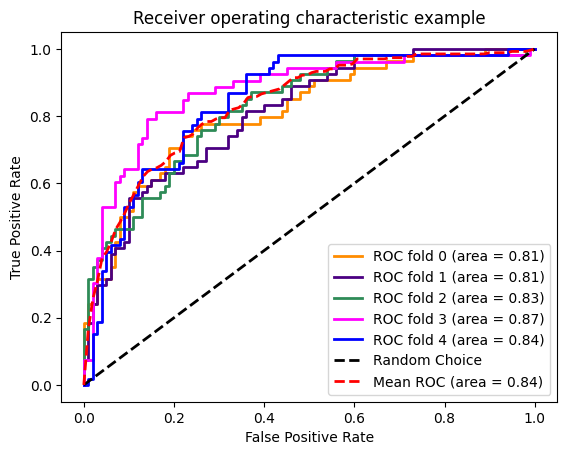

In [15]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from numpy import interp

kfold = model_selection.StratifiedKFold(n_splits=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['darkorange', 'indigo', 'seagreen', 'magenta', 'blue'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, y), colors):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute the ROC curve and the area under the curve (AUC)
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = lw, color = color, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle = '--', lw = lw, color = 'k', label = 'Random Choice')

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color = 'r', linestyle = '--', label = 'Mean ROC (area = %0.2f)' % mean_auc, lw = lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = 'lower right')
plt.show()

**Questions:**
1. In what situation would you recommend using the AUC index to assess the model quality?
2. Which of the curves shown in the plot corresponds to the best model? Justify your answer?
3. What value of the AUC parameter should be taken as an index of the model quality? Why do you think so?

**Answers:**


1. I'd definitely recommend using AUC, especially when you're dealing with **imbalanced datasets**. Remember how we saw that our diabetes dataset was unbalanced? Accuracy alone can be misleading in those cases because a model that just predicts the majority class all the time can still have high accuracy. AUC, on the other hand, looks at the trade-off between True Positive Rate and False Positive Rate across all possible thresholds, giving you a more complete picture of how well your model distinguishes between the classes, regardless of how many examples you have of each. It's also great when the costs of False Positives and False Negatives are similar, or you want a single metric to compare different models.

2. The curve that corresponds to the best model is the one that is **closest to the top-left corner** of the plot. This is because the top-left corner represents a perfect classifier with a True Positive Rate (TPR) of 1 and a False Positive Rate (FPR) of 0. In the plot, the curves that are higher and further to the left indicate better performance. The **mean ROC curve** (the red dashed line) gives you an average performance across the folds. Generally, a curve that hugs the top-left corner more closely has a higher AUC.

3. There isn't a single "magic number" for what AUC value is considered "good," as it really depends on the problem and the context. However, a model with an AUC **significantly above 0.5** is generally considered to be performing better than random chance. An AUC closer to **1.0** indicates a very good model that can effectively distinguish between the positive and negative classes. The closer your AUC is to 1.0, the better. The "Mean ROC (area = 0.84)" from the plot suggests a reasonably good model performance on average across the folds.

# 4. Bagging
**Bootstrap aggregation** (also known as **bagging**) is a model aggregation technique to reduce model variance. The training data is splited into multiple samples with replacement called as **boostrap samples**. Bootstrap sample size is same as original sample size, with **3/4th** of the original values and replacement result in repetition of values.

## Exercise 12: 5-fold cross validation and bagging

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics

import matplotlib.pyplot as plt

# Bagged decision trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Read the data in
df = pd.read_csv('/content/drive/My Drive/Lab09/Diabetes.csv')

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kfold = model_selection.StratifiedKFold(n_splits = 5)
num_trees = 100

# Dection tree with 5-fold cross validation
clf_DT = DecisionTreeClassifier().fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT, X_train, y_train, cv = kfold)
print ('Decision tree (stand alone) - train:', results.mean())
print ('Decision tree (stand alone) - test:', metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using bagging lets build 100 decision tree models and average / majority vote prediction
clf_DT_Bag = BaggingClassifier(estimator = clf_DT, n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT_Bag, X_train, y_train, cv = kfold)
print ('\nDecision tree (bagging) - train:', results.mean())
print ('Decision tree (bagging) - test:', metrics.accuracy_score(clf_DT_Bag.predict(X_test), y_test))

Decision tree (stand alone) - train: 0.7311475409836066
Decision tree (stand alone) - test: 0.7337662337662337

Decision tree (bagging) - train: 0.7817539650806344
Decision tree (bagging) - test: 0.7662337662337663


**Questions:**
1. Which method lets us to build a more accurate model? Justify your answer.
2. Could another way of splitting the data improve the results? Check this for 7-fold and 9-fold cross validation.

**Answers:**


1. Based on the test accuracies from the previous output, the **Bagging** method resulted in a slightly more accurate model (test accuracy of 0.766) compared to the stand-alone Decision Tree (test accuracy of 0.734). Bagging helps reduce variance by averaging the predictions of multiple decision trees, which often leads to better generalization on unseen data and thus a higher accuracy.

2. Yes, it's possible that using a different number of folds for cross-validation (like 7-fold or 9-fold) could potentially improve or change the results. The choice of 'k' in k-fold cross-validation can influence the bias-variance trade-off of the performance estimate. To check this, you would need to modify the `n_splits` parameter in the `StratifiedKFold` in the code cells for Exercise 12 and re-run them with `n_splits=7` and `n_splits=9`. Then you could compare the resulting average train and test accuracies to see if there's any improvement. It's worth experimenting to see what works best for this specific dataset and model!

## Exercise 13: Feature importances
Decision tree model has an attribute to show important features which is based on the **gini** or **entropy information gain**.

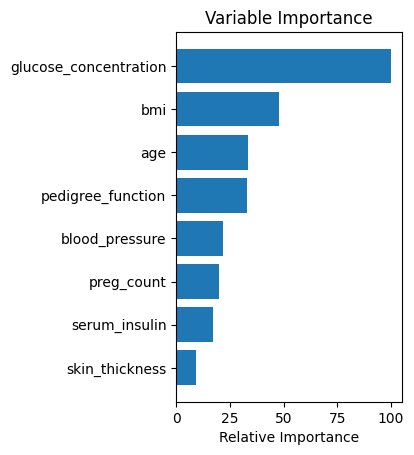

In [17]:
feature_importance = clf_DT.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Question:**
1. How do you think an information about the feature importances can be used?

**Answer:**


Information about feature importances is super valuable! You can use it in a few ways:
- **Feature Selection:** If some features have very low importance, you might consider removing them. This can simplify your model, potentially reduce overfitting, speed up training, and make data collection cheaper if those features are expensive to obtain.
- **Model Interpretation:** Feature importance helps you understand *why* your model is making certain predictions. It tells you which factors the model considers most influential in determining the outcome. This is especially useful for explaining your model to others (like stakeholders or clients) or for gaining insights into the underlying problem.
- **Domain Knowledge Validation:** Sometimes, feature importance can either confirm what you already suspected about which factors are important, or it can reveal surprising relationships in the data that you didn't anticipate.
- **Data Collection Strategies:** If a very important feature is missing or of poor quality, you know where to focus your efforts to improve your data.

## Exercise 14: Random forest
A **subset of observations** and a **subset of vairables** are randomly picked to build multiple independent **tree** based models. The trees are more un-correlated as only a subset of variables are used during the split of the tree, rather than greedily choosing the best split point in the construction of the tree.

In [18]:
from sklearn.ensemble import RandomForestClassifier
num_trees = 100

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kfold = model_selection.StratifiedKFold(n_splits = 5)

clf_RF = RandomForestClassifier(n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_RF, X_train, y_train, cv = kfold)

print ('Random forest - train:', results.mean())
print ('Random forest - test:', metrics.accuracy_score(clf_RF.predict(X_test), y_test))

Random forest - train: 0.7540983606557378
Random forest - test: 0.7987012987012987


**Questions:**
1. Is a model built using the **random forest** method better than a model built using the **bagging** method? Justify your answer.
2. Run the **random forest** model building process 5 times and note the accuracy of training and testing each time. How do you justify the different values of the results obtained?
3. How does the number of independent trees used to build a **random forest** model affect its effectiveness? Check this for several values of the **num_trees** parameter.

**Answers:**


1. Looking at the test accuracies from the previous outputs (Bagging test accuracy ~0.766, Random Forest test accuracy ~0.799), the model built using the **Random Forest** method appears to be slightly better in this instance. Random Forest introduces more randomness by also considering only a subset of features at each split, which can further reduce variance and improve generalization compared to standard Bagging, where all features are considered for each tree.

2. When you run the Random Forest model building process multiple times, you'll likely get slightly different accuracy results each time. This is due to the inherent randomness in the algorithm, specifically:
    - **Random sampling of observations:** Each tree in the forest is built on a bootstrap sample (random sampling with replacement) of the training data. These samples will be slightly different in each run.
    - **Random subset of features:** At each split in each tree, only a random subset of features is considered. This subset will vary from split to split and from tree to tree, and across different runs.
    These random elements mean that the exact composition of the training and test sets within the cross-validation folds, and the specific trees built, will vary slightly with each run, leading to variations in the final accuracy scores.

3. The number of independent trees (`num_trees`) used to build a Random Forest model generally affects its effectiveness in a few ways:
    - **Increased Effectiveness (up to a point):** Adding more trees typically improves the model's performance by reducing variance and making the predictions more stable through averaging. The more trees you have, the better the ensemble can average out the individual trees' errors.
    - **Diminishing Returns:** There's usually a point where adding more trees provides very little additional improvement in performance. The gains become smaller and smaller.
    - **Increased Computation Time:** Building more trees takes longer and requires more computational resources.
    - **Reduced Overfitting Risk (relative to single trees):** While you can technically build an infinite number of trees, a Random Forest is less prone to overfitting as you increase the number of trees, unlike a single decision tree.
    To check this for several values of `num_trees`, you would need to modify the `num_trees` variable in the code cell for Exercise 14 and run it with different values (e.g., 10, 50, 200, 500) and compare the resulting train and test accuracies. You'd likely see the test accuracy improve initially and then level off.

## Exercise 15: Extremely randomized trees
This algorithm is an effort to introduce more randomness to the **bagging** process. Tree splits are chosen completely at random from the range of values in the sample at each split which allows to *reduce the variance of the model* further, however at the cost of *slight increase in bias*.

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees = 100

X = df.iloc[:,:8].values    # Independent variables
y = df['class'].values      # Dependent variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kfold = model_selection.StratifiedKFold(n_splits = 5)

clf_ET = ExtraTreesClassifier(n_estimators = num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_ET, X_train, y_train, cv = kfold)

print ('ExtraTree - train:', results.mean())
print ('ExtraTree - test:', metrics.accuracy_score(clf_ET.predict(X_test), y_test))

ExtraTree - train: 0.7556977209116353
ExtraTree - test: 0.7987012987012987


**Questions:**
1. Compare the average accuracy of the **extremely randomized trees** and **random forest** models for **10 trials**. How do you justify your results?
2. Do you think the **test_size** parameter affects the accuracy of model testing? Justify your answer.

**Answers:**


1. To get a reliable comparison over 10 trials, you'd need to run the code cells for both Random Forest (Exercise 14) and Extremely Randomized Trees (Exercise 15) ten times each, record the test accuracy from each run, and then calculate the average for both models. Comparing these averages would give you a better idea of which model performs better on average for this dataset. The justification for any difference in results would likely come down to the increased randomness in Extremely Randomized Trees at the split points, which can sometimes lead to a slight reduction in variance compared to Random Forest, potentially resulting in a slightly different average accuracy depending on the dataset.

2. Yes, I definitely think the `test_size` parameter affects the accuracy of model testing. Here's why:
   - **Size of the test set:** A smaller test set might not be representative of the overall data distribution, leading to a test accuracy that is either overly optimistic or pessimistic. A larger test set generally provides a more reliable estimate of how the model will perform on unseen data.
   - **Size of the training set:** Conversely, a larger `test_size` means a smaller training set. Training a model on less data can lead to it not learning the underlying patterns as well, potentially resulting in lower accuracy.
   - **Variance of the estimate:** With a smaller test set (larger training set), the test accuracy can have higher variance, meaning it might fluctuate more depending on the specific split. With a larger test set (smaller training set), the variance of the test accuracy estimate is lower, but the estimate itself might be biased due to the smaller training data.
   Finding the right `test_size` is often a trade-off and can depend on the size of your dataset. Techniques like cross-validation help mitigate the impact of a single train/test split.